# ReesSaver Discriminator Agent

## Notes:
- Roughly 90% of our boards are unique
- Every time you call generate_data it gets new games/games in a different order?

In [ ]:
import chess

import chess.svg
import cv2

from IPython.display import display, SVG

import numpy as np
import random
from tqdm import tqdm
from importlib import reload
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import utils
reload(utils)
import utils

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    # Set default tensor type to CUDA tensors
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    
else:
    
    torch.set_default_tensor_type(torch.FloatTensor)
 
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

made_loader = False

True


In [3]:
torch.cuda.empty_cache()
gc.collect()

0

In [4]:
def clear_cuda():
    
    input()
    
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            if obj.is_cuda:
                print(type(obj), obj.size(), obj.device)
                del obj
    torch.cuda.empty_cache()
    gc.collect()

In [5]:
clear_cuda()

<class 'torch.Tensor'> torch.Size([64]) cuda:0


C:\Users\osama\anaconda3\lib\site-packages\torch\distributed\distributed_c10d.py:359: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [5]:
from utils.Datasets import *

import utils.Dataloading
reload(utils.Dataloading)
from utils.Dataloading import *
from utils.Game_playing import *

import utils.Playing_agents
reload(utils.Playing_agents)
from utils.Playing_agents import *

from utils.CSV_data import *
from utils.Puzzles import *

In [6]:
class MLPv2_1(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(14, 64, 3, 1, padding=1, padding_mode = 'zeros')

        self.layers = nn.ModuleList()

        self.depth = 6

        for _ in range(self.depth):
            self.layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.layers.append(nn.BatchNorm2d(64))
            self.layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.layers.append(nn.BatchNorm2d(64))

        self.linear = nn.Linear(4096, 128)

    def forward(self, x):

        x = self.conv1(x)

        for i in range(self.depth):
            j = i*4
            ph = x.clone()
            ph = self.layers[j](ph)
            ph = self.layers[j+1](ph)
            ph = F.relu(ph)
            ph = self.layers[j+2](ph)
            ph = self.layers[j+3](ph)

            x = x + ph
            x = F.relu(x)


        x = torch.flatten(x, start_dim=1)

        x = self.linear(x)

        minn, ila = x[:,:64], x[:,64:]

        return minn, ila

In [7]:
RDv2 = torch.load("Models/RDv2.3 CB.pt", map_location= device)

In [7]:
boards, meta, elo, moves, _, _, fens = generate_data("./Data/GAN_human_data.pgn", N = 30_000)

0it [00:00, ?it/s]
100%|██████████| 30000/30000 [10:17<00:00, 48.61it/s]


In [8]:
class generator_1(nn.Module):

    def __init__(self, conv_depth):

        super().__init__()
        self.conv1 = nn.Conv2d(14, 64, 3, 1, padding=1, padding_mode = 'zeros')
        
        self.conv_layers = nn.ModuleList()
        self.conv_depth = conv_depth
        
        for i in range(self.conv_depth):
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            #self.conv_layers.append(nn.BatchNorm2d(64))
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            #if i < self.conv_depth - 1:
                #self.conv_layers.append(nn.BatchNorm2d(64))

        self.linear = nn.Linear(4096, 128)

    def forward(self, x):

        x = self.conv1(x)
        
        for i in range(self.conv_depth):
            j = i*2
            ph = x.clone()
            ph = self.conv_layers[j](ph)
            #ph = self.conv_layers[j+1](ph)
            ph = F.relu(ph)
            ph = self.conv_layers[j+1](ph)
            #if i < self.conv_depth - 1:
                #ph = self.conv_layers[j+3](ph)
            
            x = x + ph
            x = F.relu(x)   
        
        x = torch.flatten(x, start_dim=1)

        x = self.linear(x)
        minn, ila = x[:,:64], x[:,64:]

        minn = F.softmax(minn, dim=1)
        ila = F.softmax(ila, dim=1)

        return torch.cat([minn, ila], dim=1).view(-1, 2, 8, 8)

In [9]:
class discriminator_1(nn.Module):

    def __init__(self, conv_depth):

        super().__init__()
        self.conv1 = nn.Conv2d(16, 64, 3, 1, padding=1, padding_mode = 'zeros')

        self.conv_layers = nn.ModuleList()
        self.conv_depth = conv_depth

        for _ in range(self.conv_depth):
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.conv_layers.append(nn.LayerNorm([64,8,8]))
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.conv_layers.append(nn.LayerNorm([64,8,8]))
            
        self.linear = nn.Linear(4096, 1)
    

    def forward(self, board, move):
        
        x = torch.cat((board, move), dim = 1)

        x = self.conv1(x)
        
        for i in range(self.conv_depth):
            j = i*2
            ph = x.clone()
            ph = self.conv_layers[j](ph)
            ph = self.conv_layers[j+1](ph)
            ph = F.leaky_relu(ph)
            ph = self.conv_layers[j+2](ph)
            ph = self.conv_layers[j+3](ph)
            
            x = x + ph
            x = F.leaky_relu(x)
                  
                  
        x = torch.flatten(x, start_dim=1)
        
        x = self.linear(x)
        x = F.sigmoid(x)
        
        return x

In [29]:
class GAN_1(nn.Module):
    #AI: 0, Human: 1
    def __init__(self, g_conv_depth, d_conv_depth, lr, pre_trained_g = None):
        
        super().__init__()
        
        print(device)
        
        self.save_every = 2

        self.alpha = 0.2
        
        if pre_trained_g is not None:
            
            self.generator = pre_trained_g
            self.pre_trained = True
        
        else:
            
            self.generator = generator_1(g_conv_depth)
            self.pre_trained = False


        self.discriminator = discriminator_1(d_conv_depth)
        
        self.logs = {"g_acc": [0], "d_acc_r": [0], "d_acc_f": [0], 
                     "g_loss": [0], "d_loss": [0],"d_dist_f": [0], "d_dist_r": [0], 
                     "cur_g_loss": 0, "cur_d_loss": 0}
        
        self.made_loader = False
        
        self.configure_optimizers(lr)
        self.categorical_loss_1 = torch.nn.CrossEntropyLoss()
        self.categorical_loss_2 = torch.nn.CrossEntropyLoss()
        
        
        
    def forward(self, x):
        return self.generator(x)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def stockfish_train(self, train_boards, moves):

        self.generator.train()
        
        self.discriminator.eval()
        
        self.opt_g.zero_grad()

        fake_moves = self(train_boards)

        moves = moves.view(-1, 128)

        if self.pre_trained:

            fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
            g_loss = self.categorical_loss_1(fake_moves[0], moves[:,:64]) + self.categorical_loss_2(fake_moves[1], moves[:,64:])
            
        else:
            
            fake_moves = fake_moves.view(-1, 128)

            g_loss = self.categorical_loss_1(fake_moves[:,:64], moves[:,:64]) + self.categorical_loss_2(fake_moves[:,64:], moves[:,64:])
            
        #g_loss = torch.sum(torch.log((y - y_hat) + epsilon), dim=0)
        
        g_loss *= self.alpha

        self.logs["cur_g_loss"] += g_loss.item()

        g_loss.backward()

        self.opt_g.step()
    
    def train_step(self, train_boards, real_moves, train_generator, prev_generator=None):

        self.discriminator.train()

        self.generator.train()

        epsilon = 1e-8
        
        #train generator
        if train_generator:
            
            self.discriminator.eval()

            self.opt_g.zero_grad()
            
            fake_moves = self(train_boards)
            
            if self.pre_trained:
                
                fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
                fake_moves = self.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8)
                
            else:
                
                fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8)
            
            y_hat = self.discriminator(train_boards, fake_moves)
            
            y = torch.zeros(real_moves.size(0), 1).to(device)
            
            g_loss = -1 * self.adversarial_loss(y_hat, y)
            #g_loss = torch.sum(torch.log((y - y_hat) + epsilon), dim=0)
                        
            self.logs["cur_g_loss"] += g_loss.item()
            
            g_loss.backward()

            self.opt_g.step()
              
        #discriminator training 
        else:

            self.generator.eval()

            self.opt_d.zero_grad()
            
            y_hat_real = self.discriminator(train_boards, real_moves)
            y_real = torch.ones(real_moves.size(0), 1).to(device)
            
            #d_real_loss = torch.sum(y_hat_real, dim = 0)
            d_real_loss = self.adversarial_loss(y_hat_real, y_real)
            
            if prev_generator is not None:
                
                prev_fake_moves = prev_generator(train_boards[:len(train_boards)//8])
                fake_moves = self(train_boards[len(train_boards)//8:])

                if self.pre_trained:

                    fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
                    fake_moves = self.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8).detach()
                    prev_fake_moves = F.softmax(prev_fake_moves[0], dim=1), F.softmax(prev_fake_moves[1], dim=1)
                    prev_fake_moves = self.diffable_argmax_moves((torch.cat(prev_fake_moves,dim=1))).view(-1,2,8,8).detach()

                else:

                    fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8).detach()
                    prev_fake_moves = self.diffable_argmax_moves(prev_fake_moves).view(-1,2,8,8).detach()
                
                fake_moves = torch.cat([prev_fake_moves, fake_moves], dim=0)

                
            else:
                
                fake_moves = self(train_boards)

                if self.pre_trained:
                    fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
                    fake_moves = self.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8).detach()

                else:

                    fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8).detach()

            
            y_hat_fake = self.discriminator(train_boards, fake_moves)
            y_fake = torch.zeros(real_moves.size(0), 1).to(device)

            #d_fake_loss = torch.sum(y_hat_fake, dim = 0)
            d_fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
            
            
            d_loss = d_fake_loss + d_real_loss # - d_fake_loss * d_real_loss
            self.logs["cur_d_loss"] += d_loss.item()
            
            d_loss.backward()

            self.opt_d.step()
            
            #for param in self.discriminator.parameters():
            #    param.data.clamp_(-0.01, 0.01)
            
    def diffable_argmax_moves(self, moves):
        
        moves = moves.view(-1,2,64)
        # Create a tensor to hold the transformed results
        transformed_tensor = torch.zeros_like(moves).to(device)
    
        # Find the indices of the maximum values along the last two dimensions
        max_indices = torch.argmax(moves, dim=2, keepdim=True).to(device) # 5000, 2
    
        # Create a mask where the maximum indices are set to 1
        idx0 = torch.arange(transformed_tensor.size(0)).unsqueeze(1).unsqueeze(2).to(device)
        idx1 = torch.arange(transformed_tensor.size(1)).unsqueeze(0).unsqueeze(2).to(device)
    
        transformed_tensor[idx0, idx1, max_indices] = 1
        
        moves = moves * transformed_tensor

        moves /= moves[idx0, idx1, max_indices]
    
        return moves
            
    
    def configure_optimizers(self, lr):
        self.lr = lr
        self.opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas = (0.5, 0.999),  weight_decay=0.0)
        self.opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr,  betas = (0.5, 0.999), weight_decay=0.0)
    
    def on_epoch_end(self, epoch, G, prefix, val_data=None):
        
        self.logs["g_loss"].append(self.logs["cur_g_loss"] / G)
        self.logs["d_loss"].append(self.logs["cur_d_loss"] / G)
        
        print(f'Epoch {epoch+1} with g_loss: {self.logs["cur_g_loss"] / G} and d_loss: {self.logs["cur_d_loss"] / G}')
        
        self.logs["cur_g_loss"] = 0
        self.logs["cur_d_loss"] = 0
        
        if epoch % 1 == 0:
            
            if val_data is not None:
                
                self.discriminator.eval()
                
                self.generator.eval()
                
                val_boards = val_data.bitboards
                real_moves = val_data.moves
                
                #fake_moves_ind = torch.argmax(fake_moves, dim=1)
                values = np.zeros(5)
                
                for i in range(0,len(val_boards), 100):
                
                    with torch.no_grad():
                        
                        curr_boards, curr_moves = val_boards[i:i+100], real_moves[i:i+100]
    
                        fake_moves = self(curr_boards)
                                                
                        if self.pre_trained:
                            
                            fake_from_moves = torch.argmax(fake_moves[0], dim=1)
                            fake_to_moves = torch.argmax(fake_moves[1], dim=1)
                            real_from_moves = torch.argmax(curr_moves[:,0].view(-1,64), dim=1)
                            real_to_moves = torch.argmax(curr_moves[:,1].view(-1,64), dim=1)
                            values[4] += torch.sum((fake_from_moves == real_from_moves) & (fake_to_moves == real_to_moves)).item()/fake_from_moves.size(0)
                        
                            fake_moves = self.diffable_argmax_moves(torch.cat([F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)], dim=1)).view(-1,2,8,8)

                        else:

                            fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8)


                        f_pred = self.discriminator(curr_boards, fake_moves)
                        r_pred = self.discriminator(curr_boards, curr_moves)
    
                        values[0] += torch.mean(torch.round(f_pred) == 0, dtype=torch.float).item() #d_acc_f
                        values[1] += torch.mean(torch.round(r_pred) == 1, dtype=torch.float).item() #d_acc_r
    
                        values[2] += torch.mean(torch.abs(f_pred)) #d_dist_f
                        values[3] += torch.mean(torch.abs(1 - r_pred)) #d_dist_r

                        if not self.pre_trained:
    
                            values[4] += torch.mean((curr_moves.view(-1,128) == torch.round(fake_moves).view(-1,128)).all(dim=1), dtype=torch.float).item() # g_acc
                                                    
                n = int(len(val_boards) // 100)
                d_acc_f, d_acc_r = values[0] / n, values[1] / n
                d_dist_f, d_dist_r = values[2] / n, values[3] / n
                g_acc = values[4] / n
                
                print(f'Epoch: {epoch+1}, {g_acc=}, {d_acc_f=}, {d_acc_r=}')
                print(f"{d_dist_f=}, {d_dist_r=}")
                
                self.logs["d_acc_f"].append(d_acc_f)
                self.logs["d_acc_r"].append(d_acc_r)
                self.logs["d_dist_f"].append(d_dist_f)
                self.logs["d_dist_r"].append(d_dist_r)
                self.logs["g_acc"].append(g_acc)
                
                
            if epoch % self.save_every == 0:
            
                torch.save(self.generator, f"{prefix}-generator {epoch}.pt")
                torch.save(self.discriminator, f"{prefix}-discriminator {epoch}.pt")
            
    def create_dataloader(self, boards, meta, moves, B, N, N_val):

        if self.made_loader:

            clear_cuda()
            
        loader = DataLoader(GANData(boards[:N], meta[:N], moves[:N]), batch_size = B, shuffle = True, generator=torch.Generator(device=device))
        val_loader = GANData(boards[N:N+N_val], meta[N:N+N_val], moves[N:N+N_val])
        
        self.made_loader = True
        
        return loader, val_loader
        

        

In [11]:
class GANData(Dataset):

    def __init__(self, bitboards, meta, moves):

        self.bitboards = torch.tensor(bitboards, dtype = torch.float).to(device)

        self.moves = torch.tensor(moves.reshape(-1,2,8,8), dtype = torch.float).to(device)

    def __len__(self):

        return self.moves.size(dim=0)


    def __getitem__(self, idx):

        return self.bitboards[idx], self.moves[idx]
    
    

In [126]:
for _ in range(4): clear_cuda()

<class 'torch.Tensor'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 14, 3, 3]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 4096]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([128]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.Tensor'> torch.Size([64]) cuda:0
<class 'torch.Tensor'> torch.Size([64]) cuda:0
<class 'torch.Tensor'> torch.Size([]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.Tensor

In [39]:
del RSv1

In [30]:
del loader
del val_data

In [42]:
RSv1 = GAN_1(g_conv_depth=6, d_conv_depth=6, lr=0.0002, pre_trained_g=None).to(device)

cuda


In [22]:
loader, val_data = RSv1.create_dataloader(boards, meta, human_moves, B = 128, N=len(boards)-4_001, N_val=4_000) # try B = 128
G = len(loader)

In [41]:
torch.cuda.empty_cache()
gc.collect()

0

In [32]:
RSv1.opt_g = torch.optim.Adam(RSv1.generator.parameters(), lr=0.00075, betas = (0.5, 0.999),  weight_decay=0.0)

In [36]:
del RSv1.discriminator

RSv1.discriminator = discriminator_1(conv_depth=4)
RSv1.configure_optimizers(0.001)

In [32]:
del RSv1.generator

RSv1.generator = generator_1(conv_depth=6)
RSv1.configure_optimizers(0.001)

In [24]:
train_discriminator = False
train_all = True
train_generator = False

In [25]:
r_bound, f_bound = 0.75,0.7
not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound)

True

In [26]:
save_thresh = 0

In [43]:
prefix = "BasicGAN"
for epoch in range(0,50):

    reps = 0

    if train_all or train_discriminator:
        prev_generator = None

        if epoch > RSv1.save_every + 1 and not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            choice = np.random.choice(np.arange(start=RSv1.save_every, stop= (epoch//(RSv1.save_every+1) * RSv1.save_every)+1, step = RSv1.save_every))

            prev_generator = torch.load(f'{prefix}-generator {choice}.pt', map_location= device)
    
        while not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            
            reps += 1
            if reps > 20:
                train_all = False
                train_discriminator = False
                train_generator = False
                break

            i=0
            
            for bitboards, mvs in tqdm(loader):
                if i > G // 2:
                    break
                RSv1.train_step(bitboards, mvs, train_generator=False, prev_generator=prev_generator)
                i += 1

            print('Discriminator Training')
            RSv1.on_epoch_end(epoch, G,  prefix, val_data)


    reps = 0
    if train_all or train_generator:
        while (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            reps += 1
            if reps > 20:
                train_all = False
                train_generator = False
                train_discriminator = False
                break

            i=0
            for bitboards, mvs in tqdm(loader):

                if i > G // 1:
                   break

                RSv1.train_step(bitboards, mvs, train_generator=True)
                i += 1
            
            print('Generator Training')
            RSv1.on_epoch_end(epoch, G,  prefix,  val_data)
            
            if RSv1.logs["g_acc"][-1] > save_thresh:
                save_thresh = RSv1.logs["g_acc"][-1]
                torch.save(RSv1.generator, f"StockGAN_RDv2_acc{save_thresh}.pt")
            
        

 50%|█████     | 3710/7418 [01:03<01:03, 58.41it/s]


Discriminator Training
Epoch 1 with g_loss: 0.0 and d_loss: 0.01984932302100059
Epoch: 1, g_acc=0.0012499999720603228, d_acc_f=0.9979999959468842, d_acc_r=0.9957499817013741
d_dist_f=0.0029053444042801855, d_dist_r=0.0051368772983551025


100%|██████████| 7418/7418 [01:47<00:00, 69.03it/s]


Generator Training
Epoch 1 with g_loss: -0.1935240814132083 and d_loss: 0.0
Epoch: 1, g_acc=0.0, d_acc_f=0.46899998709559443, d_acc_r=0.9957499817013741
d_dist_f=0.5233109951019287, d_dist_r=0.0051368772983551025


 50%|█████     | 3710/7418 [01:02<01:02, 59.34it/s]


Discriminator Training
Epoch 2 with g_loss: 0.0 and d_loss: 0.020383594635012516
Epoch: 2, g_acc=0.0, d_acc_f=0.9974999919533729, d_acc_r=0.9979999914765358
d_dist_f=0.0030429648235440255, d_dist_r=0.0041373327374458315


100%|██████████| 7418/7418 [01:48<00:00, 68.62it/s]


Generator Training
Epoch 2 with g_loss: -0.00418573184682164 and d_loss: 0.0
Epoch: 2, g_acc=0.0, d_acc_f=0.9992499962449074, d_acc_r=0.9979999914765358
d_dist_f=0.0009851831942796706, d_dist_r=0.0041373327374458315


100%|██████████| 7418/7418 [01:48<00:00, 68.50it/s]


Generator Training
Epoch 2 with g_loss: -0.002451480722255028 and d_loss: 0.0
Epoch: 2, g_acc=0.0, d_acc_f=1.0, d_acc_r=0.9979999914765358
d_dist_f=0.0003872070461511612, d_dist_r=0.0041373327374458315


 20%|██        | 1519/7418 [00:22<01:28, 66.79it/s]


KeyboardInterrupt: 

In [27]:
RSv1.on_epoch_end(2, G,  "BasicGAN", None)

Epoch 3 with g_loss: 0.0 and d_loss: 0.0


In [25]:
pd.DataFrame.from_dict(RSv1.logs).to_csv('Results/StockGAN-RDv2.csv', index = None)

In [26]:
old_generator = torch.load("Models/RDv2.3 CB.pt", map_location= device)
RSv1.generator = torch.load("StockGAN_RDv2_acc0.39400000000000013.pt", map_location=device)

In [28]:
old_generator_model = lambda x: network_agent_prob_conv(x, lambda y: old_generator(y))
generator_model = lambda x: network_agent_prob_conv(x, lambda y: RSv1(y))
#generator_model = lambda x: network_agent_prob_conv(x, lambda y: (RSv1.generator(y).view(-1,128)))

In [30]:
test_against(old_generator_model, generator_model, N=500, unique=True)

100%|██████████| 250/250 [01:58<00:00,  2.10it/s]


(61, 358, 81, 0.122)

In [28]:
fake_moves = test_gen(val_data.bitboards)

fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
fake_moves = torch.cat(fake_moves,dim=1).view(-1,2,8,8).detach()

torch.mean(test_disc(val_data.bitboards, fake_moves))

tensor(0.0005, grad_fn=<MeanBackward0>)

In [76]:
test_gen = torch.load("Models/RDv2.3 CB.pt", map_location=device)

In [21]:
fake_moves = RSv1(val_data.bitboards[:100])

fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
fake_moves = RSv1.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8).detach()
print(fake_moves[0])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]])


In [61]:
RSv1.discriminator(val_data.bitboards[0:1], fake_moves[0:1])

TypeError: eval() takes 1 positional argument but 2 were given

In [115]:
new_val = torch.round(fake_moves[0:1])

In [49]:
counter = 13

In [50]:
torch.all(val_data.moves[counter] == fake_moves[counter])

tensor(False)

In [58]:
val_data.bitboards[0:1].shape

torch.Size([1, 14, 8, 8])

In [62]:
RSv1.discriminator.eval()
RSv1.discriminator(val_data.bitboards[counter:counter+3], val_data.moves[counter:counter+3])

tensor([[3.5519e-03],
        [1.9832e-03],
        [5.9222e-08]], grad_fn=<SigmoidBackward0>)

In [63]:
RSv1.discriminator(val_data.bitboards[counter:counter+1], fake_moves[counter:counter+1])

tensor([[0.0024]], grad_fn=<SigmoidBackward0>)

# Stockfish GAN

In [12]:
def load_stockfish_data(N=2_000_000):
    
    file_path = "Data/StockData.csv"
    new_data = True
    epsilon = 1e-5
    
    df = pd.read_csv(file_path, nrows=N)
    ind_map = index_map.cpu().numpy()
    
    
    df.dropna(axis=0, inplace=True)
    df.reset_index(inplace=True)

    
    fens = np.array(df['FENs'])
    moves = np.zeros((len(fens), 128))
    h_moves = np.zeros((len(fens), 128))

    bitboards, meta = zip(*[fen_to_board(x) for x in tqdm(fens, total=len(fens))])
    
    bitboards = np.asarray(bitboards)

    meta = np.asarray(meta)
    
    if new_data:

        moves[df.index,df['stock_moves'].apply(lambda x: chess.Move.from_uci(x).from_square)] = 1
        moves[df.index, 64 + df['stock_moves'].apply(lambda x: chess.Move.from_uci(x).to_square)] = 1
        
    else:
        
        for i in tqdm(range(4)):
            
            moves[df.index,df[f'move{i}'].apply(lambda x: chess.Move.from_uci(x).from_square)] += df[f'eval{i}'] + epsilon
            moves[df.index, 64 + df[f'move{i}'].apply(lambda x: chess.Move.from_uci(x).to_square)] += df[f'eval{i}'] + epsilon
        
    
    h_moves[df.index, df["hmoves"].apply(lambda x: chess.Move.from_uci(x).from_square)] = 1
    h_moves[df.index, 64 + df["hmoves"].apply(lambda x: chess.Move.from_uci(x).to_square)] = 1
    
    flipped_moves = np.zeros_like(moves)    
    flipped_moves[:,:64] = moves[:,ind_map]
    flipped_moves[:,64:] = moves[:,64+ind_map]
    #v_fens = np.vectorize(fen_to_board)
    moves = np.where(np.expand_dims(meta, 1), moves, flipped_moves)

    flipped_moves = np.zeros_like(h_moves)
    flipped_moves[:,:64] = h_moves[:,ind_map]
    flipped_moves[:,64:] = h_moves[:,64+ind_map]
    #v_fens = np.vectorize(fen_to_board)
    h_moves = np.where(np.expand_dims(meta, 1), h_moves, flipped_moves)
    
    #bitboards = np.array(list(map(fen_to_board, fens)))
    
    del df
    
    
    return bitboards, meta, h_moves, moves

In [13]:
print('Kernel saved')

Kernel saved


In [14]:
boards, meta, human_moves, stock_moves = load_stockfish_data(500_000)

100%|██████████| 500000/500000 [07:47<00:00, 1070.11it/s]


In [54]:
test_discriminator = torch.load("Models/StockGAN/discriminator 6.pt")
test_generator = torch.load("Models/StockGAN/generator 6.pt")

In [21]:
torch.mean(test_discriminator(torch.tensor(boards[:1000], dtype=torch.float), torch.tensor(stock_maxmoves[:1000], dtype=torch.float).view(-1,2,8,8)))

tensor(0.6572, grad_fn=<MeanBackward0>)

In [55]:
num_samples = 5000
test_generator.eval()
ai_moves = test_generator(torch.tensor(boards[:num_samples], dtype=torch.float))

In [56]:
ai_moves = ai_moves.view(5000, 128).detach().cpu()

In [50]:
ai_moves = RSv1.diffable_argmax_moves(torch.cat([ai_moves[0], ai_moves[1]], dim = 1)).view(-1,128).detach().cpu()

In [15]:
stock_noise = np.random.uniform(low = 0, high = 1e-6, size = stock_moves.shape)
print(stock_noise[:5])

[[8.96252815e-07 5.54740632e-07 2.82778967e-07 9.97050991e-07
  5.15450548e-07 8.56230156e-07 8.88985452e-07 8.90846889e-07
  1.62689170e-07 1.26445707e-07 4.18896885e-07 9.90336431e-07
  5.90766688e-08 2.57920543e-07 8.18890459e-07 6.52590343e-07
  1.12924585e-07 6.59827495e-08 1.79162249e-07 9.26542648e-07
  3.05664467e-07 4.17475634e-07 6.80336533e-07 5.18829982e-07
  1.22801870e-07 5.60642105e-07 9.71069396e-07 8.09582577e-07
  8.41275178e-07 5.43626629e-07 4.41134487e-07 1.75101523e-08
  2.29159837e-07 3.96879068e-07 2.85584221e-07 7.38117052e-07
  8.63113542e-07 1.23752096e-07 6.74661651e-08 9.60774156e-07
  7.41347611e-08 2.40753799e-07 5.31088403e-07 9.42260871e-08
  4.45399450e-07 7.28351680e-07 9.69149007e-07 2.68432228e-07
  6.32634585e-07 2.32795715e-07 1.19681510e-07 5.38292480e-07
  7.65188072e-07 3.00512851e-07 7.95322374e-07 9.56565912e-07
  6.19336732e-07 4.24447714e-07 1.67386756e-07 2.94386172e-07
  4.75547907e-07 5.73834599e-07 9.97078595e-08 3.76911519e-07
  2.8292

In [16]:
stock_maxmoves = np.zeros_like(stock_moves)
stock_maxmoves[np.arange(len(stock_moves)), np.argmax(stock_moves[:,:64] + stock_noise[:,:64], axis = 1)] = 1
stock_maxmoves[np.arange(len(stock_moves)), 64 + np.argmax(stock_moves[:,64:] + stock_noise[:,64:], axis = 1)] = 1

In [53]:
df = pd.DataFrame({"Axis Number" : list(range(128))})

df['RDv2 mean'] = torch.mean(ai_moves, axis=0)
df['RDv2 std'] = torch.std(ai_moves, axis=0)

df['Human mean'] =  np.mean(human_moves, axis= 0)
df['Human std'] = np.std(human_moves, axis= 0)
df['Stock mean'] = np.mean(stock_maxmoves, axis= 0)
df['Stock std'] = np.std(stock_maxmoves, axis= 0)

#df['Distance'] = np.abs((df['AI mean'] - df['Human mean'])/df['Human mean'])
#df.sort_values(['Distance'], inplace= True)
print(df.drop('Axis Number', axis = 1))

     RDv2 mean  RDv2 std  Human mean  Human std  Stock mean  Stock std
0       0.0254  0.157352    0.024259   0.153853    0.024258   0.153850
1       0.0270  0.162100    0.027148   0.162514    0.028379   0.166054
2       0.0386  0.192659    0.038954   0.193486    0.035294   0.184521
3       0.0376  0.190246    0.045448   0.208284    0.055144   0.228262
4       0.0562  0.230331    0.044122   0.205366    0.031583   0.174886
..         ...       ...         ...        ...         ...        ...
123     0.0042  0.064678    0.006133   0.078071    0.005139   0.071506
124     0.0052  0.071930    0.004862   0.069555    0.004272   0.065221
125     0.0040  0.063125    0.004559   0.067370    0.003769   0.061273
126     0.0004  0.019998    0.002424   0.049174    0.002230   0.047169
127     0.0014  0.037394    0.003083   0.055436    0.002427   0.049206

[128 rows x 6 columns]


In [57]:
df['StockGAN mean'] = torch.mean(ai_moves, axis=0)
df['StockGAN std'] = torch.std(ai_moves, axis=0)

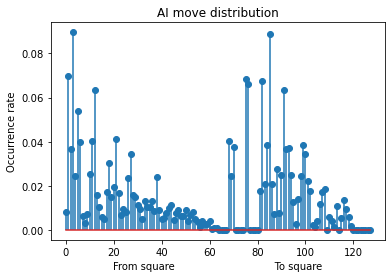

In [48]:
plt.stem(df.index, df['AI mean'])
plt.ylabel("Occurrence rate")
plt.xlabel("From square                                To square")
plt.title(" move distribution")
plt.savefig("Results/StockGAN_mean.png")

In [38]:
df[df["AI mean"] > 0.02]

,Axis Number,AI mean,AI std,Human mean,Human std,Stock mean,Stock std,Distance
12,12,0.5,0.707107,0.038249,0.191797,0.039720,0.195300,12.072161
82,82,0.5,0.707107,0.035182,0.184240,0.034124,0.181548,13.211684
18,18,0.5,0.707107,0.034003,0.181238,0.035136,0.184124,13.704417
70,70,0.5,0.707107,0.029655,0.169633,0.021157,0.143907,15.860697


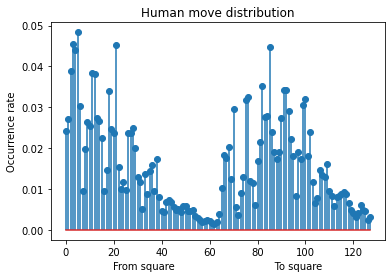

In [44]:
plt.stem(df.index, df['Human mean'])
plt.ylabel("Occurrence rate")
plt.xlabel("From square                                To square")
plt.title("Human move distribution")
plt.savefig("Results/Human_mean.png")

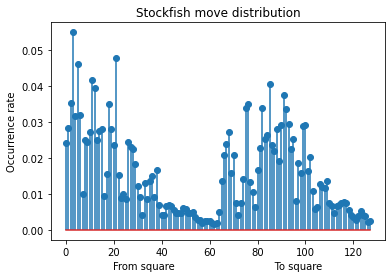

In [45]:
plt.stem(df.index, df['Stock mean'])
plt.ylabel("Occurrence rate")
plt.xlabel("From square                                To square")
plt.title("Stockfish move distribution")
plt.savefig("Results/stock_mean.png")

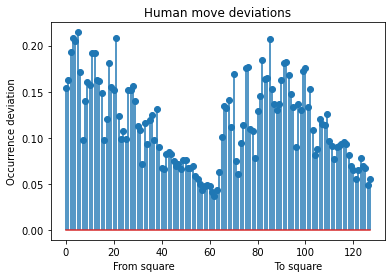

In [47]:
plt.stem(df.index, df["Human std"])
plt.ylabel("Occurrence deviation")
plt.xlabel("From square                                To square")
plt.title("Human move deviations")
plt.savefig("Results/human_std.png")

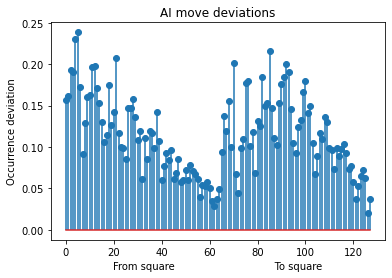

In [48]:
plt.stem(df.index, df["AI std"])
plt.ylabel("Occurrence deviation")
plt.xlabel("From square                                To square")
plt.title("AI move deviations")
plt.savefig("Results/AI_std.png")

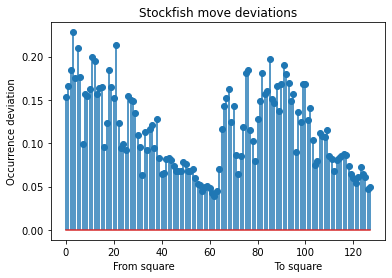

In [49]:
plt.stem(df.index, df["Stock std"])
plt.ylabel("Occurrence deviation")
plt.xlabel("From square                                To square")
plt.title("Stockfish move deviations")
plt.savefig("Results/stock_std.png")

In [15]:
class StockData(Dataset):

    def __init__(self, bitboards, moves, stock_moves):

        self.bitboards = torch.tensor(bitboards, dtype = torch.float).to(device)

        self.moves = torch.tensor(moves, dtype = torch.float).view(-1,2,8,8).to(device)
        self.stock_moves = torch.tensor(stock_moves, dtype=torch.float).view(-1,2,8,8).to(device)

    def __len__(self):

        return self.moves.size(dim=0)


    def __getitem__(self, idx):

        return self.bitboards[idx], self.moves[idx], self.stock_moves[idx]
    

In [38]:
del RSv1

In [39]:
RSv1 = GAN_1(g_conv_depth=6, d_conv_depth=6, lr=0.0002, pre_trained_g=RDv2).to(device)

cuda


In [32]:
val_size = 2_000
B = 128
loader = DataLoader(StockData(boards[:-val_size], human_moves[:-val_size], stock_moves[:-val_size]), batch_size = B, shuffle = True, generator=torch.Generator(device=device))
val_data = StockData(boards[-val_size:], human_moves[-val_size:], stock_moves[-val_size:])
G = len(loader)

In [41]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
del RSv1.discriminator

RSv1.discriminator = discriminator_1(conv_depth=4)
RSv1.configure_optimizers(0.001)

In [ ]:
del RSv1.generator

RSv1.generator = generator_1(conv_depth=6)
RSv1.configure_optimizers(0.0002)

In [46]:
train_discriminator = False
train_all = True
train_generator = False

r_bound, f_bound = 0.6, 0.6

In [44]:
save_thresh = 0

In [59]:
prefix = "StockGAN-RDv2"
for epoch in range(50):

    reps = 0

    if train_all or train_discriminator:
        prev_generator = None

        if epoch > RSv1.save_every + 1 and not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            choice = np.random.choice(np.arange(start=RSv1.save_every, stop= (epoch//(RSv1.save_every+1) * RSv1.save_every)+1, step = RSv1.save_every))

            prev_generator = torch.load(f'{prefix}-generator {choice}.pt', map_location= device)

        while not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):

            reps += 1
            if reps > 20:
                train_all = False
                train_discriminator = False
                train_generator = False
                break

            i=0

            for bitboards, mvs, _ in tqdm(loader):
                if i > G // 1:
                    break
                RSv1.train_step(bitboards, mvs, train_generator=False, prev_generator=prev_generator)
                i += 1

            print('Discriminator Training')
            RSv1.on_epoch_end(epoch, G, prefix, val_data)


    reps = 0
    if train_all or train_generator:

        while (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            reps += 1
            if reps > 20:
                train_all = False
                train_generator = False
                train_discriminator = False
                break

            i=0
            for bitboards, mvs, stk_mvs in tqdm(loader):
                if i > G // 1:
                    break

                RSv1.train_step(bitboards, mvs, train_generator=True)
                RSv1.stockfish_train(bitboards, stk_mvs)
                i += 1

            print('Generator Training')
            RSv1.on_epoch_end(epoch, G, prefix, val_data )
            
            if RSv1.logs["g_acc"][-1] > save_thresh:
                save_thresh = RSv1.logs["g_acc"][-1]
                torch.save(RSv1.generator, f"{prefix}-acc_{save_thresh}.pt")
            
        

100%|██████████| 3891/3891 [01:50<00:00, 35.15it/s]


Generator Training
Epoch 1 with g_loss: 1.1716305581808275 and d_loss: 0.0
Epoch: 1, g_acc=0.386, d_acc_f=0.6244999885559082, d_acc_r=0.6214999854564667
d_dist_f=0.4158209800720215, d_dist_r=0.407623815536499


100%|██████████| 3891/3891 [01:47<00:00, 36.04it/s]


Generator Training
Epoch 1 with g_loss: 0.8325836021224321 and d_loss: 0.0
Epoch: 1, g_acc=0.38, d_acc_f=0.6274999856948853, d_acc_r=0.6214999854564667
d_dist_f=0.4118049144744873, d_dist_r=0.407623815536499


100%|██████████| 3891/3891 [01:47<00:00, 36.10it/s]


Generator Training
Epoch 1 with g_loss: 0.8189324451439548 and d_loss: 0.0
Epoch: 1, g_acc=0.3755, d_acc_f=0.6164999812841415, d_acc_r=0.6214999854564667
d_dist_f=0.4165057182312012, d_dist_r=0.407623815536499


100%|██████████| 3891/3891 [01:50<00:00, 35.24it/s]


Generator Training
Epoch 1 with g_loss: 0.8066265681919846 and d_loss: 0.0
Epoch: 1, g_acc=0.38049999999999995, d_acc_f=0.6144999861717224, d_acc_r=0.6214999854564667
d_dist_f=0.4173689365386963, d_dist_r=0.407623815536499


100%|██████████| 3891/3891 [01:49<00:00, 35.38it/s]


Generator Training
Epoch 1 with g_loss: 0.7963385244195242 and d_loss: 0.0
Epoch: 1, g_acc=0.37849999999999995, d_acc_f=0.6184999883174896, d_acc_r=0.6214999854564667
d_dist_f=0.41969051361083987, d_dist_r=0.407623815536499


100%|██████████| 3891/3891 [01:49<00:00, 35.66it/s]


Generator Training
Epoch 1 with g_loss: 0.7872827774575791 and d_loss: 0.0
Epoch: 1, g_acc=0.3725, d_acc_f=0.6119999915361405, d_acc_r=0.6214999854564667
d_dist_f=0.419127082824707, d_dist_r=0.407623815536499


 12%|█▏        | 454/3891 [00:13<01:40, 34.36it/s]


KeyboardInterrupt: 

In [ ]:
pd.DataFrame.from_dict(RSv1.logs).to_csv('Results/StockGAN_RDv2.csv', index = None)

In [56]:
new_generator = torch.load("StockGAN-RDv2-acc_0.4025.pt")
old_generator = torch.load("Models/BasicGAN/BasicGAN_RDv2_acc0.394.pt")

In [61]:
loader.dataset.moves.resize_(len(loader.dataset), 2, 8, 8)
loader.dataset.stock_moves.resize_(len(loader.dataset), 2, 8, 8)
val_data.moves.resize_(len(val_data), 2, 8, 8)
val_data.stock_moves.resize_(len(val_data), 2, 8, 8)

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           5.1000e-04, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000

In [41]:
np.mean(np.all(human_moves == stock_moves, axis=1))

0.3946939809620326

In [60]:
old_generator_model = lambda x: network_agent_prob_conv(x, lambda y: RSv1(y))
generator_model = lambda x: network_agent_prob_conv(x, lambda y: (new_generator(y)))

In [61]:
test_against(generator_model, old_generator_model, N=500, unique=True)

100%|██████████| 250/250 [01:56<00:00,  2.14it/s]


(259, 52, 189, 0.518)

In [ ]:
play_game(old_generator_model, generator_model, show_boards=True)